Embeddings caricati. Shape: (35826, 1024)
Calcolo metriche di validità interna per diversi k…


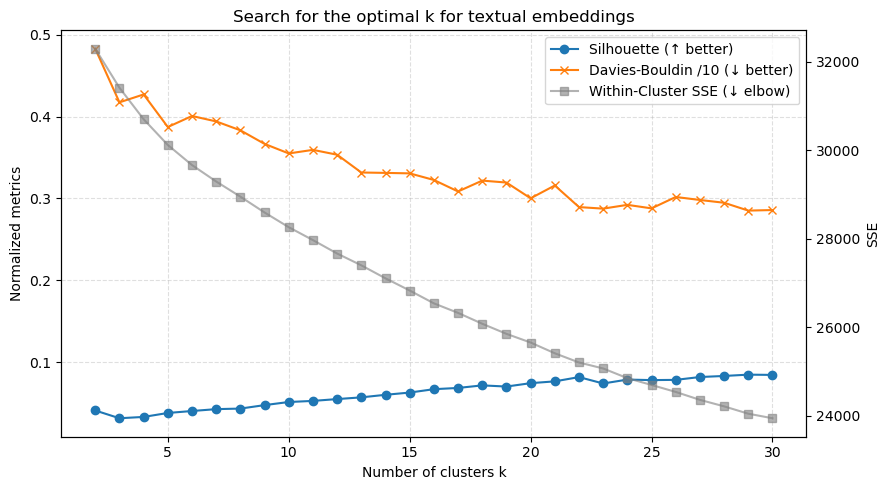


❱❱  k with max silhouette ≃ 29



In [12]:
# ────────────────────────────────────────────────
# Blocco 1 – Valutazione quantitativa dei cluster TESTUALI
# Obiettivo: trovare k “ottimale” e motivare la bontà dei cluster
# ────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --- Caricamento Dati ---
path_annotation_embedding = '../MLPC2025_dataset/annotations_text_embeddings.npz'
path_annotations_csv = '../MLPC2025_dataset/annotations.csv'

# Carica gli embeddings
try:
    data_annotations = np.load(path_annotation_embedding)
    anno_embeddings = data_annotations["embeddings"]
    print(f"Embeddings caricati. Shape: {anno_embeddings.shape}") # Shape: (35826, embedding_dim) [cite: 8]
except FileNotFoundError:
    print(f"Errore: File embedding non trovato in {path_annotation_embedding}")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento degli embedding: {e}")
    exit()

# Range di k da testare
k_values = list(range(2, 31))    # 2 … 30
sil_scores, db_scores, inertias = [], [], []

print("Calcolo metriche di validità interna per diversi k…")
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(anno_embeddings)
    labels = km.labels_
    inertias.append(km.inertia_)                            # SSE (elbow)
    sil_scores.append(silhouette_score(anno_embeddings, labels, sample_size=10000))
    db_scores.append(davies_bouldin_score(anno_embeddings, labels))

# ── Comparative chart
fig, ax1 = plt.subplots(figsize=(9,5))
ax1.plot(k_values, sil_scores, marker='o', label='Silhouette (↑ better)')
ax1.plot(k_values, [s/10 for s in db_scores], marker='x', label='Davies-Bouldin /10 (↓ better)')
ax1.set_xlabel("Number of clusters k")
ax1.set_ylabel("Normalized metrics")
ax1.grid(True, linestyle='--', alpha=.4)

ax2 = ax1.twinx()
ax2.plot(k_values, inertias, marker='s', color='grey', alpha=.6, label='Within-Cluster SSE (↓ elbow)')
ax2.set_ylabel("SSE")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc='best')

plt.title("Search for the optimal k for textual embeddings")
plt.tight_layout()
plt.show()

# I choose k with maximum silhouette (or elbow) and save it
best_k = k_values[int(np.argmax(sil_scores))]
print(f"\n❱❱  k with max silhouette ≃ {best_k}\n")


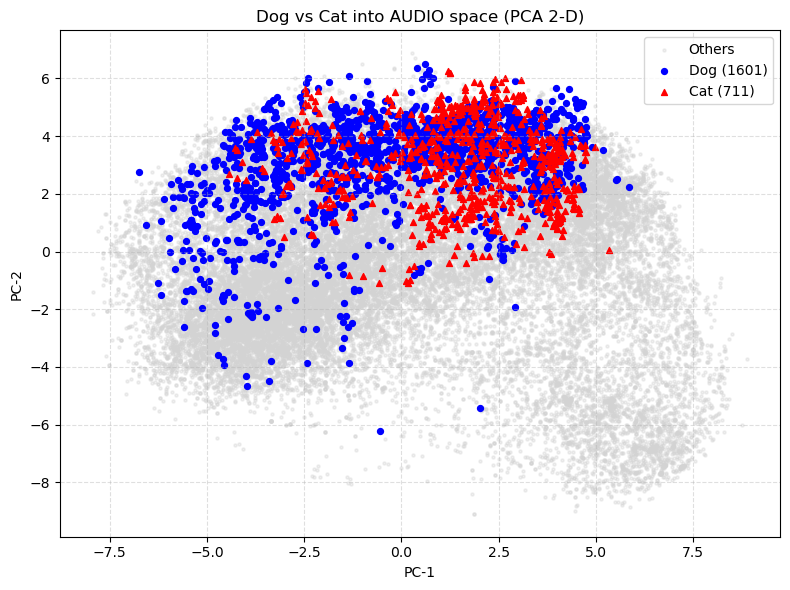


Global Silhouette (dog+cat) : 0.163
  • Dog : 0.151
  • Cat : 0.189


In [13]:
# ────────────────────────────────────────────────
# Bootstrap: carico di nuovo gli array necessari
# ────────────────────────────────────────────────
import numpy as np
import os, sys, pandas as pd

DATA_DIR = "../MLPC2025_dataset"

# ---------------- helper ----------------
def get_average_audio_features(row, base_path, frame_duration, feature_key):
    import numpy as np, os, re
    filename, onset, offset = row['filename'], row['onset'], row['offset']
    m = re.match(r'(\d+)\.mp3$', str(filename))
    if not m: return None
    fpath = os.path.join(base_path, f"{m.group(1)}.npz")
    if not os.path.exists(fpath): return None
    data = np.load(fpath)
    if feature_key not in data: return None
    feats = data[feature_key]                       # (frames, feat_dim)
    s = int(onset  // frame_duration)
    e = int(offset // frame_duration)
    e = min(max(e, s+1), feats.shape[0])           # almeno 1 frame
    return feats[s:e].mean(axis=0)
# ----------------------------------------


# --- Embedding testuali -------------------------------------------------------
npz_text = os.path.join(DATA_DIR, "annotations_text_embeddings.npz")
anno_embeddings = np.load(npz_text)["embeddings"]      # shape (35826, 1024)

# --- DataFrame annotazioni ----------------------------------------------------
csv_anno = os.path.join(DATA_DIR, "annotations.csv")
annotations_df = pd.read_csv(csv_anno)                # 35 826 righe

# --- Feature audio medie ------------------------------------------------------
# ⃟  Opzione A: le hai già salvate in un .npy /.npz:
precomp = os.path.join(DATA_DIR, "average_audio_features.npy")
if os.path.exists(precomp):
    average_audio_features_array = np.load(precomp)   # shape (35826, 768)
else:
    # ⃟  Opzione B: ricomputo al volo (≈2-3 min) — usa il codice del Task 4.3
    from pathlib import Path
    #  ▸ incolla qui la funzione get_average_audio_features(... )  ⬅
    AUDIO_DIR = Path(DATA_DIR) / "audio_features"
    FRAME_DURATION_SEC = 0.120
    FEATURE_KEY = "embeddings"

    print("Ricalcolo average_audio_features_array… (può richiedere qualche minuto)")
    feats = []
    for _, row in annotations_df.iterrows():
        feats.append(get_average_audio_features(row, AUDIO_DIR, FRAME_DURATION_SEC, FEATURE_KEY))
    average_audio_features_array = np.vstack(feats)
    np.save(precomp, average_audio_features_array)    # salvataggio per le prossime volte

# ────────────────────────────────────────────────
# Blocco 2 – Compattezza DOG / CAT nello spazio AUDIO
# ────────────────────────────────────────────────
import numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# 1. Indici dog / cat
dog_idx = annotations_df[annotations_df["text"].str.contains(r"\b(?:dog|dogs)\b",
                                                             case=False, regex=True, na=False)].index
cat_idx = annotations_df[annotations_df["text"].str.contains(r"\b(?:cat|cats)\b",
                                                             case=False, regex=True, na=False)].index

# 2. PCA 2-D sugli average_audio_features
pca_audio = PCA(n_components=2, random_state=42)
audio_2d   = pca_audio.fit_transform(average_audio_features_array)

# 3. Scatter-plot
plt.figure(figsize=(8,6))
plt.scatter(audio_2d[:,0], audio_2d[:,1], s=5,  c="lightgray", alpha=.35, label="Others")
plt.scatter(audio_2d[dog_idx,0], audio_2d[dog_idx,1], s=18, c="blue",  marker="o", label=f"Dog ({len(dog_idx)})")
plt.scatter(audio_2d[cat_idx,0], audio_2d[cat_idx,1], s=18, c="red",   marker="^", label=f"Cat ({len(cat_idx)})")
plt.title("Dog vs Cat into AUDIO space (PCA 2-D)")
plt.xlabel("PC-1"); plt.ylabel("PC-2")
plt.legend(); plt.grid(ls="--", alpha=.4); plt.tight_layout(); plt.show()

# 4. Silhouette binaria (dog / cat)
labels_bin         = np.full(len(average_audio_features_array), -1)
labels_bin[dog_idx] = 0
labels_bin[cat_idx] = 1
mask_valid         = labels_bin != -1                             # solo dog+cat

sil_bin = silhouette_score(average_audio_features_array[mask_valid],
                           labels_bin[mask_valid])
sil_samp = silhouette_samples(average_audio_features_array[mask_valid],
                              labels_bin[mask_valid])

print(f"\nGlobal Silhouette (dog+cat) : {sil_bin:.3f}")
print(f"  • Dog : {sil_samp[labels_bin[mask_valid]==0].mean():.3f}")
print(f"  • Cat : {sil_samp[labels_bin[mask_valid]==1].mean():.3f}")

In [14]:
from sklearn.manifold import TSNE
import umap

# t-SNE 2-D (inizializzo con PCA per stabilità)
tsne = TSNE(n_components=2, perplexity=40, n_iter=800,
            init='pca', learning_rate='auto', random_state=42)
emb_tsne  = tsne.fit_transform(average_audio_features_array)

# UMAP 2-D
umap_reducer = umap.UMAP(n_neighbors=30, min_dist=0.1,
                         metric='cosine', random_state=42)
emb_umap = umap_reducer.fit_transform(average_audio_features_array)


/opt/anaconda3/envs/retina/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/anaconda3/envs/retina/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/retina/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


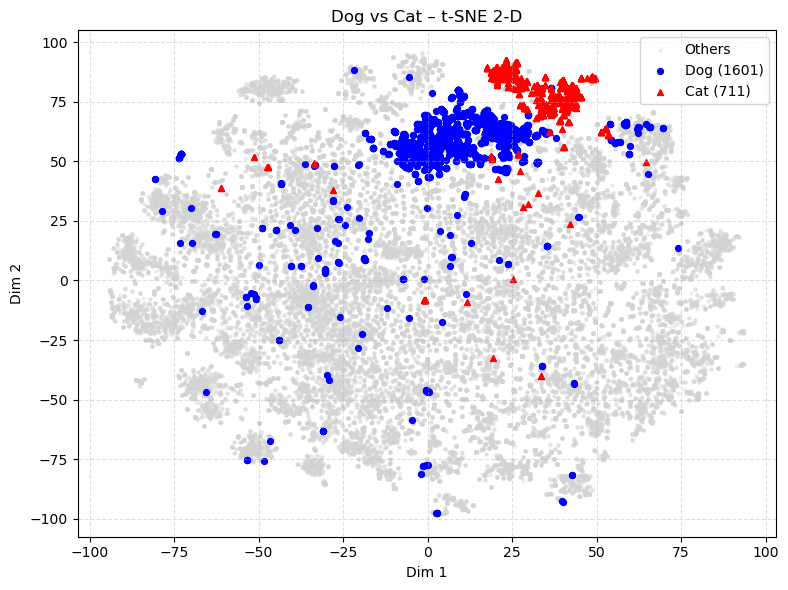

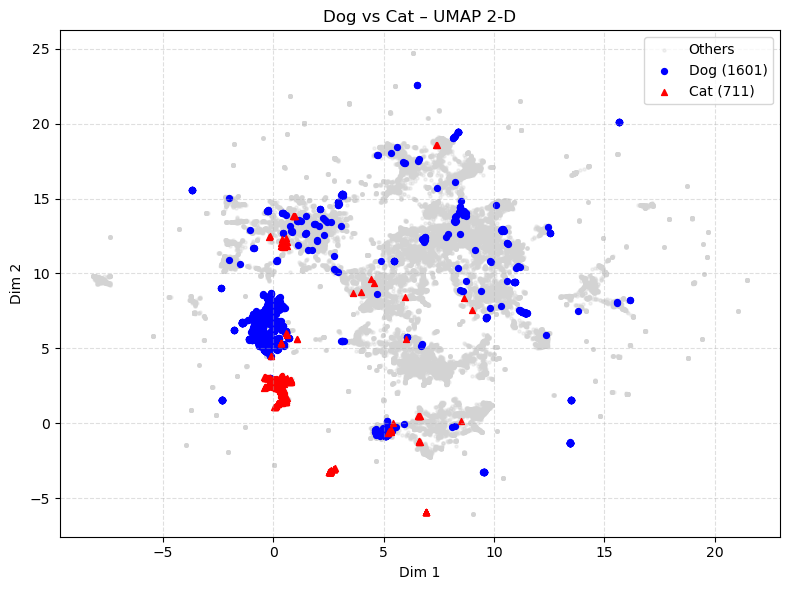

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dog_cat(emb2d, title, dog_idx, cat_idx):
    """
    emb2d   : ndarray shape (N, 2) – coordinate 2-D
    dog_idx : indici delle annotazioni 'dog'
    cat_idx : indici delle annotazioni 'cat'
    """
    plt.figure(figsize=(8,6))
    plt.scatter(emb2d[:,0], emb2d[:,1], s=5, c='lightgray',
                alpha=.30, label='Others')
    plt.scatter(emb2d[dog_idx,0], emb2d[dog_idx,1], s=18,
                c='blue', marker='o', label=f'Dog ({len(dog_idx)})')
    plt.scatter(emb2d[cat_idx,0], emb2d[cat_idx,1], s=18,
                c='red',  marker='^', label=f'Cat ({len(cat_idx)})')
    plt.title(title)
    plt.xlabel('Dim 1'); plt.ylabel('Dim 2')
    plt.legend(); plt.grid(ls='--', alpha=.4)
    plt.tight_layout(); plt.show()

plot_dog_cat(emb_tsne, "Dog vs Cat – t-SNE 2-D", dog_idx, cat_idx)
plot_dog_cat(emb_umap, "Dog vs Cat – UMAP 2-D", dog_idx, cat_idx)


Adjusted Rand Index (ARI) = 0.130
Normalized Mutual Info    (NMI) = 0.258


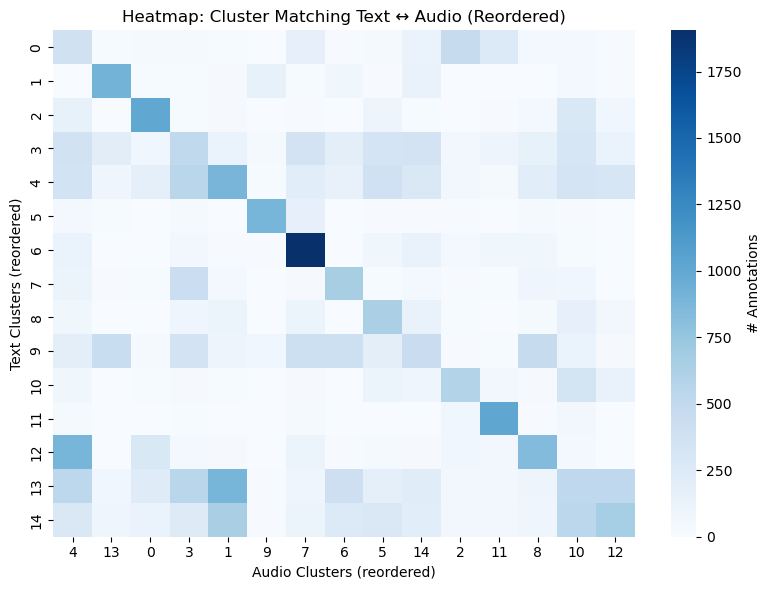

Text cluster  0  ↔ Audio cluster  4  →  22.5% of its annotations
Text cluster  1  ↔ Audio cluster 13  →  63.0% of its annotations
Text cluster  2  ↔ Audio cluster  0  →  57.5% of its annotations
Text cluster  3  ↔ Audio cluster  3  →  15.5% of its annotations
Text cluster  4  ↔ Audio cluster  1  →  21.8% of its annotations
Text cluster  5  ↔ Audio cluster  9  →  72.0% of its annotations
Text cluster  6  ↔ Audio cluster  7  →  73.9% of its annotations
Text cluster  7  ↔ Audio cluster  6  →  41.9% of its annotations
Text cluster  8  ↔ Audio cluster  5  →  43.6% of its annotations
Text cluster  9  ↔ Audio cluster 14  →  13.3% of its annotations
Text cluster 10  ↔ Audio cluster  2  →  38.5% of its annotations
Text cluster 11  ↔ Audio cluster 11  →  80.7% of its annotations
Text cluster 12  ↔ Audio cluster  8  →  34.1% of its annotations
Text cluster 13  ↔ Audio cluster 10  →  11.6% of its annotations
Text cluster 14  ↔ Audio cluster 12  →  18.1% of its annotations


In [16]:
# ────────────────────────────────────────────────
# Blocco 3 – Allineamento Audio↔Testo: ARI, NMI e heat-map
# Obiettivo: quantificare la corrispondenza tra cluster audio e testuali
# ────────────────────────────────────────────────
import seaborn as sns
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans

best_k = 15

# (Ri)‐clustering audio usando lo stesso k scelto per il testo (best_k)
km_audio = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(average_audio_features_array)
audio_lbl = km_audio.labels_
text_lbl  = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit_predict(anno_embeddings)

# 1. Metriche globali
ari = adjusted_rand_score(text_lbl, audio_lbl)
nmi = normalized_mutual_info_score(text_lbl, audio_lbl)
print(f"Adjusted Rand Index (ARI) = {ari:.3f}")
print(f"Normalized Mutual Info    (NMI) = {nmi:.3f}")

# 2. Contingency matrix + optimal reassignment (Hungarian algorithm) for heatmap
cont_table = pd.crosstab(text_lbl, audio_lbl)
# Sort rows/columns to maximize diagonal
row_ind, col_ind = linear_sum_assignment(-cont_table.values)
cont_opt = cont_table.iloc[row_ind, col_ind]
plt.figure(figsize=(8,6))
sns.heatmap(cont_opt, annot=False, cmap='Blues', cbar_kws={'label':'# Annotations'})
plt.title("Heatmap: Cluster Matching Text ↔ Audio (Reordered)")
plt.xlabel("Audio Clusters (reordered)")
plt.ylabel("Text Clusters (reordered)")
plt.tight_layout(); plt.show()

# 3. Quick print of top 3 matches
for i,(r,c) in enumerate(zip(row_ind, col_ind)):
    pct = cont_table.iloc[r,c] / cont_table.iloc[r].sum() * 100
    print(f"Text cluster {r:2d}  ↔ Audio cluster {c:2d}  → {pct:5.1f}% of its annotations")